# Product detection in Retail with YOLOv5

In this notebook, I have utilized Roboflow to annotate, split and pre-process the input images and prepare an efficient dataset for this task. A custom YOLOv5 model is then trained to detect the products on the shelfs in a retail store.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output

%matplotlib inline

import numpy as np
import cv2

from PIL import Image

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 11212, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 11212 (delta 0), reused 4 (delta 0), pack-reused 11205
Receiving objects: 100% (11212/11212), 11.13 MiB | 15.04 MiB/s, done.
Resolving deltas: 100% (7753/7753), done.
/content/yolov5
     |████████████████████████████████| 596 kB 4.4 MB/s 
     |████████████████████████████████| 138 kB 6.0 MB/s 
     |████████████████████████████████| 1.1 MB 37.6 MB/s 
     |████████████████████████████████| 145 kB 47.4 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 178 kB 46.4 MB/s 
     |████████████████████████████████| 63 kB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.

# Accessing annotated and preprocessed data from Roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="ultralytics")

upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=ultralytics


In [ ]:
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="4gcIaa9QTyKzbQ0Vo3je")
project = rf.workspace("hardik-srivastava").project("shelf-auditing-for-retail-v2.1")
dataset = project.version(1).download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to /content/datasets/shelf-auditing-for-retail-v2.1-1 in yolov5pytorch:: 100%|██████████| 2997/2997 [00:05<00:00, 574.28it/s]


In [ ]:
%cat {dataset.location}/data.yaml

names:
- object
nc: 1
train: /content/datasets/shelf-auditing-for-retail-v2.1-1/train/images
val: /content/datasets/shelf-auditing-for-retail-v2.1-1/valid/images


# Training custom YOLOv5 model

In [ ]:
!python train.py --img 640 --batch 8 --epochs 100 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

train: weights=yolov5s.pt, cfg=, data=/content/datasets/shelf-auditing-for-retail-v2.1-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-20-gacc58c1 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, 

### Evaluating performance of our trained model

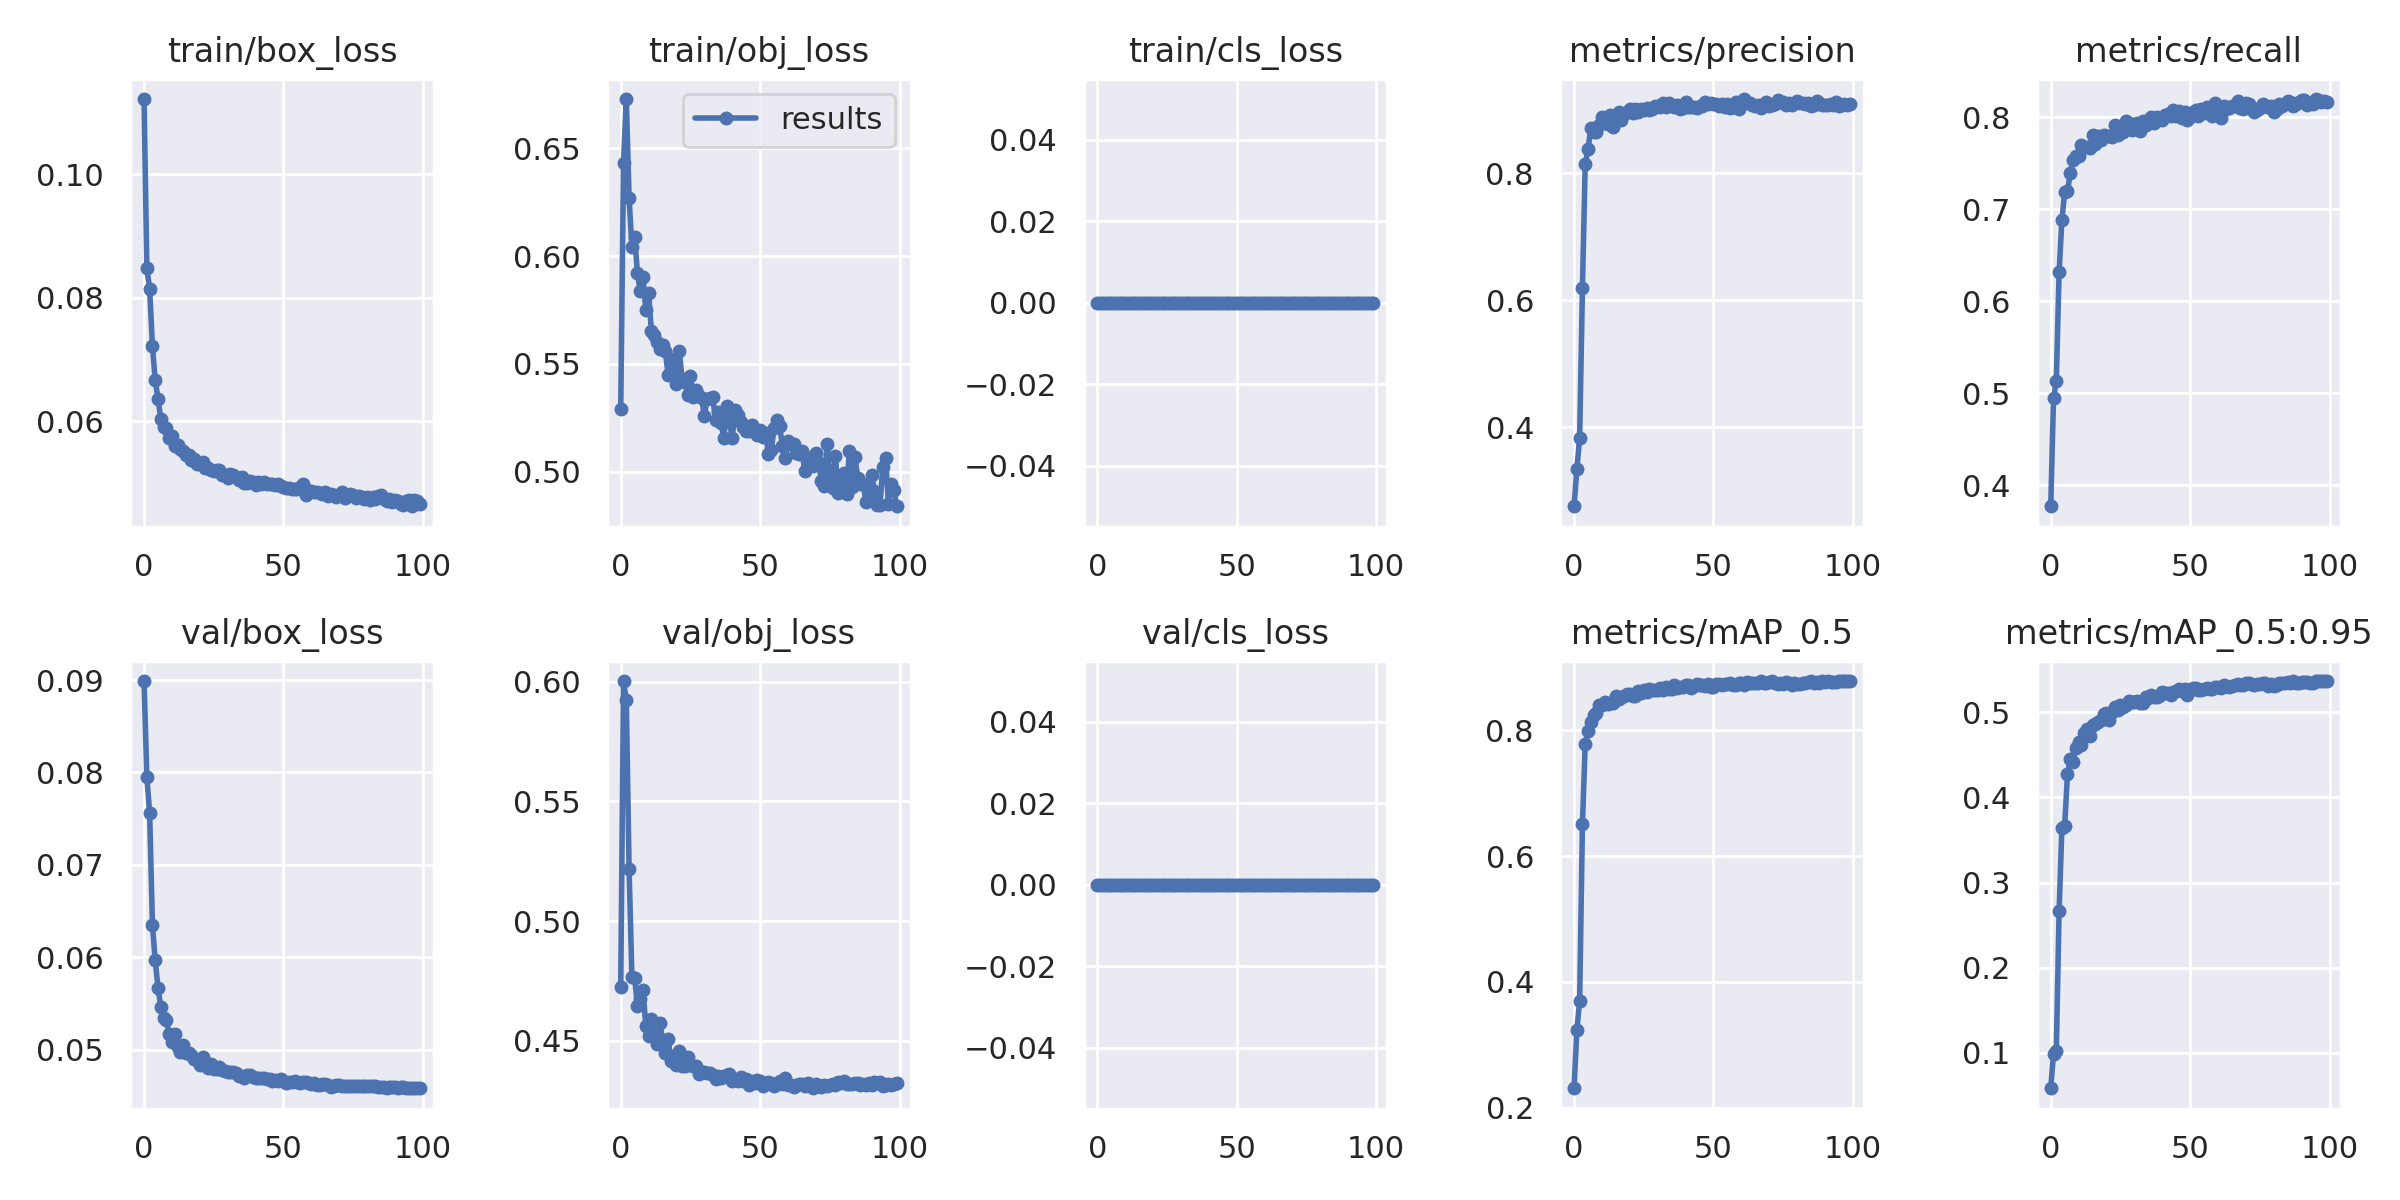

In [ ]:
Image(filename='/content/yolov5/runs/train/exp/results.png', width=1000)

### Running Inference With Trained Weights

In [63]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.55 --source {dataset.location}/test --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/datasets/shelf-auditing-for-retail-v2.1-1/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.55, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-20-gacc58c1 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model Summary: 213 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/250 /content/datasets/shelf-auditing-for-retail-v2.1-1/test/db1.jpg: 480x640 22 objects, Done. (0.030s)
image 2/250 /content/datasets/shelf-auditing-for-retail-v2.1-1/test/db10.jpg: 480x640 50 objects, Done. (0.030s)
image 3/250 /content/datasets/shelf-auditing-for-retail-v2.1-1/test/db100.jpg: 480x640 13 objects, Done. (0.030s)


### Saving in Google drive

In [71]:
!cp -a /content/yolov5/. /content/drive/MyDrive/Product-Detection/

### Bounding boxes predicted by the trained YOLOv5 model on test set.
Here the images provided in the assignment are used for testing

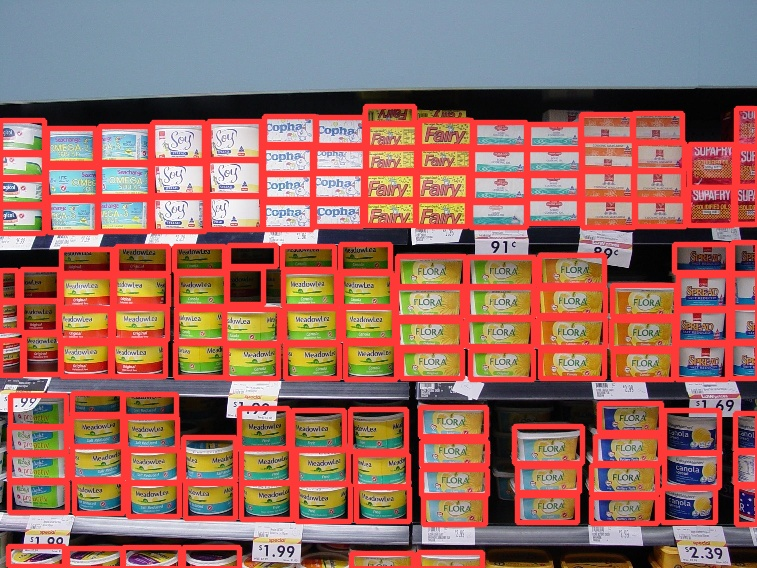

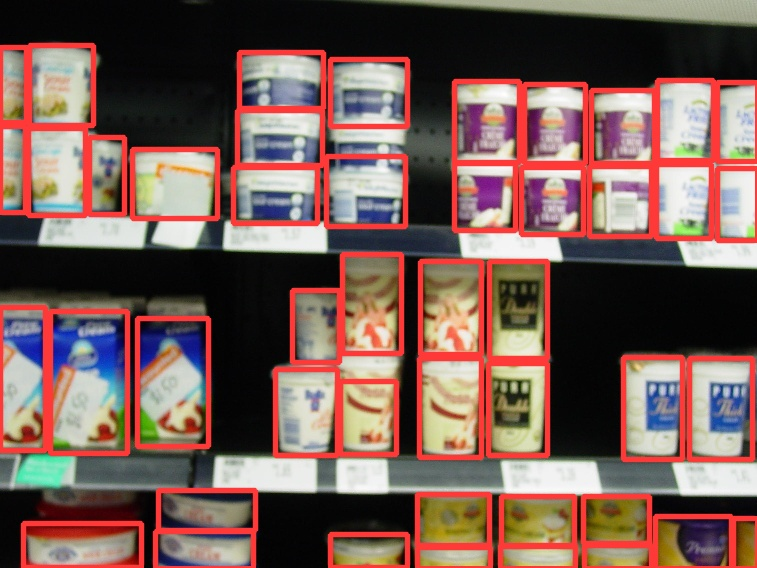

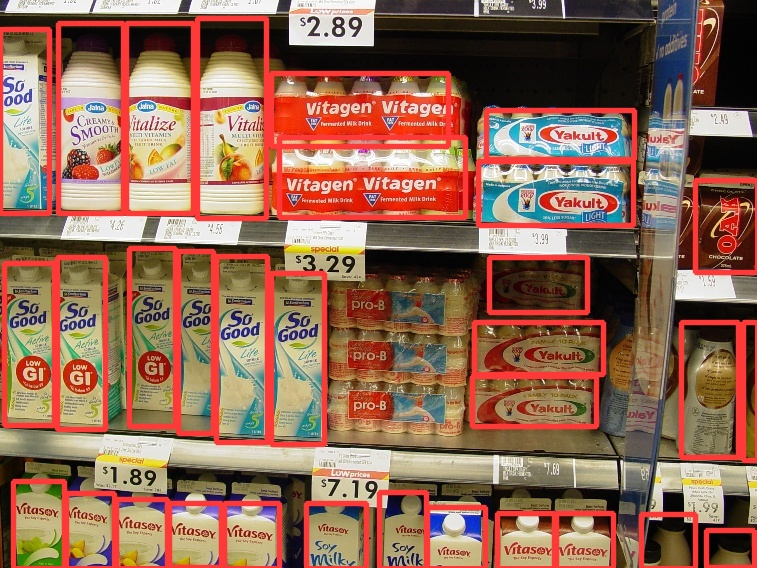

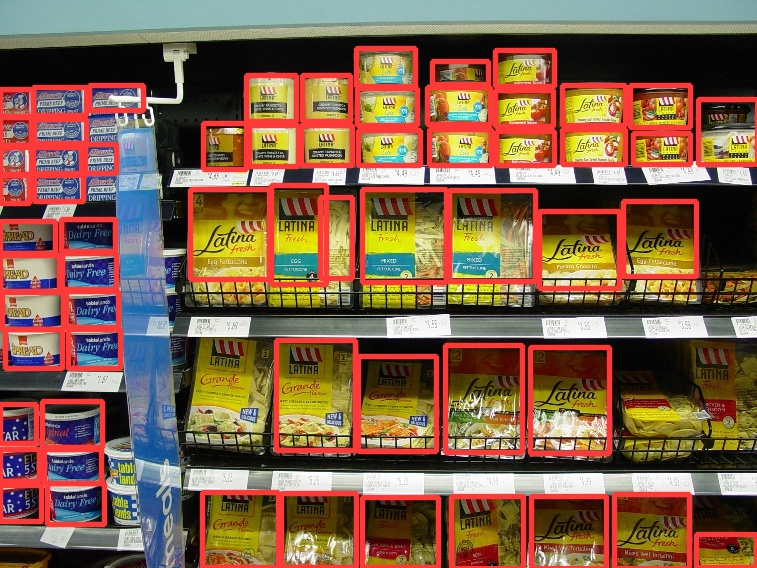

In [64]:
import glob
from IPython.display import Image, display

count=1

for imageName in glob.glob('/content/yolov5/runs/detect/exp4/*.jpg'):
    if count == 5:
      break
    count = count + 1
    display(Image(filename=imageName))
    print("\n")

### Saving all annotations in desired format

In [ ]:
annotations = sorted(glob('/content/yolov5/runs/detect/exp4/labels/*.txt'))
images = sorted(glob('/content/yolov5/runs/detect/exp4/*.jpg'))

solution_file = open("/content/yolov5/solution_2.txt","w")

for annt_file in annotations:
  with open(annt_file) as f:
    x = f.read()
    bbox_info = x.strip().split('\n')

    f_name = os.path.splitext(os.path.basename(annt_file))[0]

    temp_img = cv2.imread(f"/content/yolov5/runs/detect/exp4/{f_name}.jpg")
    dh = temp_img.shape[0]
    dw = temp_img.shape[1]

    for i in range(len(bbox_info)):
      cls, x, y, w, h = map(float, bbox_info[i].split(' '))
      l = int((x - w / 2) * dw)
      r = int((x + w / 2) * dw)
      t = int((y - h / 2) * dh)
      b = int((y + h / 2) * dh)

      if l < 0:
        l = 0
      if r > dw - 1:
          r = dw - 1
      if t < 0:
          t = 0
      if b > dh - 1:
          b = dh - 1

      details = [f_name, " "*len(f_name[2:]), str(int(cls)), " ", str(l), " ", str(r), " ", str(t), " ", str(b), "\n"]
      solution_file.writelines(details)

solution_file.close()
f.close()

In [13]:
from google.colab import files
files.download('./runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>